# Import

In [5]:
import pandas as pd

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import numpy as np

In [8]:
import importlib
import efrc_ml_production as ml
importlib.reload(ml)

/home/modules/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/modules/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


<module 'efrc_ml_production' from '/home/rgur/py_scripts/efrc_ml_production.py'>

In [9]:
from sklearn.metrics import r2_score as r2

In [10]:
from os import listdir
from os.path import isfile, join

# Define variables

In [11]:
results_dir = '/data/rgur/efrc/ml/results/'

In [12]:
stacked_path = '/data/rgur/efrc/prep_data/all_v1/stacked.csv'
ml_d_path = '/data/rgur/efrc/prep_data/all_v1/ml_data.csv'

In [13]:
Y_DATA_PATH = '/data/rgur/efrc/data_DONOTTOUCH/hMOF_allData_March25_2013.xlsx'

In [14]:
stacked = pd.read_csv('/data/rgur/efrc/prep_data/all_v1/stacked.csv')
ml_d = pd.read_csv('/data/rgur/efrc/prep_data/all_v1/ml_data.csv')

/home/modules/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/modules/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
ml_d = ml.merge_data(ml_d, False, Y_DATA_PATH)

In [16]:
stacked_map = {}
for i in stacked[['filename', 'pressure','vol_uptake']].iterrows():
    val = i[1]
    stacked_map[(val['filename'], val['pressure'])] = val['vol_uptake']

In [17]:
grav_map = {}
for i in ml_d[['filename', 'CH4_cm3/g_35_bar']].iterrows():
    val = i[1]
    grav_map[val['filename']] = val['CH4_cm3/g_35_bar']

# Define functions

In [18]:
def getMetrics(true, pred, metrics):
    '''
    Get metric values from a list if metric functions
    '''
    return [f(true, pred) for f in metrics]

In [19]:
def checkIsoFile(filename):
    '''
    Determine whether or not filename should be included
    '''
    if filename[-4:] == '.csv':
        if 'iso' in filename:
            with open(filename, 'r') as handle:
                row_count = sum(1 for row in handle) - 1
            if row_count == 533430:
                return True
    return False

In [20]:
def checkGravFile(filename):
    '''
    Determine whether or not filename should be included
    '''
    if filename[-4:] == '.csv':
        if 'grav' in filename:
            with open(filename, 'r') as handle:
                row_count = sum(1 for row in handle) - 1
            if row_count == 126369:
                return True
    return False

In [21]:
def get_t_pct(filename):
    return float(filename.split('train_')[1][:2])

In [22]:
def get_Code(filename):
    return filename.split('code_')[1][:4]

In [23]:
def getSeed(filename):
    return filename.split('seed_')[1][:1]

In [24]:
def getAllFilenames(parent_dir):
    return [parent_dir+f for f in listdir(parent_dir) if isfile(join(parent_dir, f))]

In [25]:
def getTruthVals(train_keys, test_keys, my_map):
    train_truth = [my_map[f] for f in train_keys]
    test_truth = [my_map[f] for f in test_keys]
    return train_truth, test_truth

In [26]:
def getPredsAndKeys(df):
    n_unique_pressures = len(df['Pressure'].unique())
    train_df = df[df['Class'] == 'Train']
    test_df = df[df['Class'] == 'Test']
    train_preds = train_df['Prediction'].tolist()
    test_preds = test_df['Prediction'].tolist()
    if n_unique_pressures == 1:
        train_keys = train_df['Filename'].tolist()
        test_keys = test_df['Filename'].tolist()
    else:
        train_keys = [tuple(r) for r in train_df.to_numpy()]
        test_keys = [tuple(r) for r in test_df.to_numpy()]
    return train_preds, train_keys, test_preds, test_keys

In [27]:
def get_time(f):
    return '_'.join(f.split('.')[0].split('_')[-6:])

In [28]:
def unflatten(l, n):
    new = []
    length = len(l)
    prev = 0
    split_inds = list(range(0, length+1, n))
    prev = 0
    for ind in split_inds[1:]:
        new.append(l[prev:ind])
        prev = ind
    return new

In [29]:
def getMetricsFromDf(f, fix_preds):
    df = pd.read_csv(f)
    if fix_preds:
        fix_predictions(df)
    train_preds, train_keys, test_preds, test_keys = getPredsAndKeys(df)
    train_truth, test_truth = getTruthVals(train_keys, test_keys, grav_map)
    train_vals = getMetrics(true=train_truth, pred=train_preds, metrics=[ml.get_rmse, r2])
    test_vals = getMetrics(true=test_truth, pred=test_preds, metrics=[ml.get_rmse, r2])
    return (train_vals, test_vals)

In [48]:
def getResultsDf(good_codes=None, good_time=None, fix_preds=True, include_geo=False, stacked=False):
    
    seeds = []
    run1_r2s = []
    run1_rmses = []
    run2_r2s = []
    run2_rmses = []
    run3_r2s = []
    run3_rmses = []
    train_pcts = []
    codes = []
    classes = []
    all_files = getAllFilenames(results_dir)
    #relevant_iso = [checkIsoFile(f) for f in all_files]
    if stacked:
        checkFile = checkIsoFile
    else:
        checkFile = checkGravFile
    relevent = [f for f in all_files if checkFile(f)]
    unique_codes = list(set([get_Code(f) for f in relevent]))
    if include_geo:
        good_codes = [code for code in unique_codes if code[-1] == '1']
    else:
        good_codes = [code for code in unique_codes if code[-1] == '0']
    print(good_codes)
    if good_codes != None:
        relevent = [f for f in relevent if get_Code(f) in good_codes]
    if good_time != None:
        relevent = [f for f in relevent if get_time(f) in good_time]
    relevent = sorted(relevent)
    nested_relevent = unflatten(relevent, 3)
    for l in nested_relevent:
        f = l[0]
        codes += [get_Code(f)]*2
        classes.append("Train")
        classes.append("Test")
        #seeds += [getSeed(f)]*2
        train_pcts += [get_t_pct(f)]*2
        vals = [getMetricsFromDf(f, fix_preds) for f in l] #[seed 0, seed 1, seed 2], [train, test], [rmse, r2]
        #print(vals)
        run1_r2s.append(vals[0][0][1])
        run1_r2s.append(vals[0][1][1])
        
        run1_rmses.append(vals[0][0][0])
        run1_rmses.append(vals[0][1][0])
        
        run2_r2s.append(vals[1][0][1])
        run2_r2s.append(vals[1][1][1])
        
        run2_rmses.append(vals[1][0][0])
        run2_rmses.append(vals[1][1][0])
        
        run3_r2s.append(vals[2][0][1])
        run3_r2s.append(vals[2][1][1])
        
        run3_rmses.append(vals[2][0][0])
        run3_rmses.append(vals[2][1][0])

    return pd.DataFrame({"Run 1 R2": run1_r2s, "Run 1 RMSE": run1_rmses, "Run 2 R2": run2_r2s, 
                         "Run 2 RMSE": run2_rmses, "Run 3 R2": run3_r2s, "Run 3 RMSE": run3_rmses, 
                         "Training %": train_pcts, "Code": codes, "Class": classes})

In [31]:
def labelFromCode(code):
    s = ''
    if code[0] == '1':
        s+='SI+'
    if code[1] == '1':
        s+='SD+'
    if code[2] == '1':
        s+='LS+'
    if code[3] == '1':
        s+='Geo+'
    return s[:-1]

In [32]:
def fix_predictions(df):
    preds = df['Prediction'].tolist()
    new = []
    for i in preds:
        if i<0:
            new.append(0)
        else:
            new.append(i)
    df['Prediction'] = new

In [53]:
def plot_results(df, title='Learning Curve', good_codes=None, score_name='RMSE', ylim=None, axes=None):
    colors = ['r', 'g', 'k', 'b', 'c', 'm', 'y', 'darkorange', 'slategray', 'tan', 'deeppink', 'greenyellow']
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(8, 8))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(score_name)
    if good_codes == None:
        good_codes = df['Code'].unique().tolist()
    
    for ind, code in enumerate(good_codes):
        LABEL = labelFromCode(code)
        df_code = df[df['Code'] == code]
        train_df = df_code[df_code['Class'] == 'Train']
        test_df = df_code[df_code['Class'] == 'Test']
        rmse_train_df = train_df[['Run 1 RMSE', 'Run 2 RMSE', 'Run 3 RMSE']]
        rmse_test_df = test_df[['Run 1 RMSE', 'Run 2 RMSE', 'Run 3 RMSE']]
        train_sizes = df['Training %'].unique()
    
        RMSE_train_scores_mean = np.mean(rmse_train_df, axis=1)
        RMSE_train_scores_std = np.std(rmse_train_df, axis=1)
        RMSE_test_scores_mean = np.mean(rmse_test_df, axis=1)
        RMSE_test_scores_std = np.std(rmse_test_df, axis=1)
        #fit_times_mean = np.mean(fit_times, axis=1)
        #fit_times_std = np.std(fit_times, axis=1)

        train_scores_mean = RMSE_train_scores_mean
        train_scores_std = RMSE_train_scores_std
        test_scores_mean = RMSE_test_scores_mean
        test_scores_std = RMSE_test_scores_std
        
        # Plot learning curve
        n_done = len(train_scores_mean) #in case not all runs are done yet
        axes.grid()
        axes.fill_between(train_sizes[0:n_done], train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                             color=colors[ind])
        axes.fill_between(train_sizes[0:n_done], test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1,
                             color=colors[ind])
        axes.plot(train_sizes[0:n_done], train_scores_mean, 'o-', color=colors[ind],
                     label="Training %s - %s" %(score_name, LABEL) )
        axes.plot(train_sizes[0:n_done], test_scores_mean, 'x-', color=colors[ind],
                     label="Test %s - %s" %(score_name, LABEL) )
    axes.legend(loc="best")

    return plt

# Scratch

In [11]:
df = pd.read_csv('/data/rgur/efrc/prep_data/all_v1/stacked.csv')

/home/modules/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
'results_grav_code_1100_train_70_seed_20_09_51AM_on_April_17_2020.csv'.split('code_')[1][:4]

'1100'

In [40]:
df = pd.read_csv('/data/rgur/efrc/ml/results/results_grav_code_1000_train_50_seed_20_09_51AM_on_April_17_2020.csv')

In [41]:
df.head()

,Unnamed: 0,Filename,Pressure,Class,Prediction
0,0,hypotheticalMOF_28999_i_2_j_6_k_2_m_1_cat_1.cif,35,Train,-7.725647
1,1,hypotheticalMOF_5069430_i_2_j_24_k_1_m_9.cif,35,Train,305.337952
2,2,hypotheticalMOF_6193_i_0_j_10_k_6_m_3_cat_1.cif,35,Train,92.068481
3,3,hypotheticalMOF_5073689_i_2_j_26_k_0_m_13.cif,35,Train,3.087921
4,4,hypotheticalMOF_5070072_i_2_j_24_k_10_m_9.cif,35,Train,256.223694


In [49]:
fix_predictions(df)
df.head()

,Unnamed: 0,Filename,Pressure,Class,Prediction
0,0,hypotheticalMOF_28999_i_2_j_6_k_2_m_1_cat_1.cif,35,Train,0.000000
1,1,hypotheticalMOF_5069430_i_2_j_24_k_1_m_9.cif,35,Train,305.337952
2,2,hypotheticalMOF_6193_i_0_j_10_k_6_m_3_cat_1.cif,35,Train,92.068481
3,3,hypotheticalMOF_5073689_i_2_j_26_k_0_m_13.cif,35,Train,3.087921
4,4,hypotheticalMOF_5070072_i_2_j_24_k_10_m_9.cif,35,Train,256.223694


In [25]:
len(results_df['Pressure'].unique())

1

# Test functions

In [10]:
getMetrics([1,0,0], [1,0,0], [ml.get_rmse, r2]) 

[0.0, 1.0]

In [77]:
a = '/data/rgur/efrc/ml/results/results_grav_code_1110_train_60_seed_0_12_34PM_on_April_17_2020.csv'

In [53]:
checkGravFile(a)

False

In [53]:
unflatten([0,1,2,3,4,6,7,8,9], 3)

[[0, 1, 2], [3, 4, 6], [7, 8, 9]]

In [3]:
#GOOD_CODES = ['1010', '1000']
GOOD_TIME = ['08_37PM_on_April_18_2020']

In [55]:
results_df = getResultsDf(good_codes=None, good_time=GOOD_TIME, fix_preds=True, include_geo=True, stacked=True)

[]


In [50]:
results_df.head()

,Run 1 R2,Run 1 RMSE,Run 2 R2,Run 2 RMSE,Run 3 R2,Run 3 RMSE,Training %,Code,Class
0,0.999206,2.956456,0.999257,2.854170,0.999319,2.736541,50.0,1001,Train
1,0.990838,10.016761,0.990710,10.105099,0.990493,10.210687,50.0,1001,Test
2,0.999227,2.931591,0.999276,2.835498,0.999441,2.496915,60.0,1001,Train
3,0.991569,9.508137,0.991481,9.564714,0.990854,9.882140,60.0,1001,Test
4,0.999394,2.588375,0.999298,2.791824,0.999319,2.737227,70.0,1001,Train


In [51]:
%matplotlib inline

4


<module 'matplotlib.pyplot' from '/home/modules/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

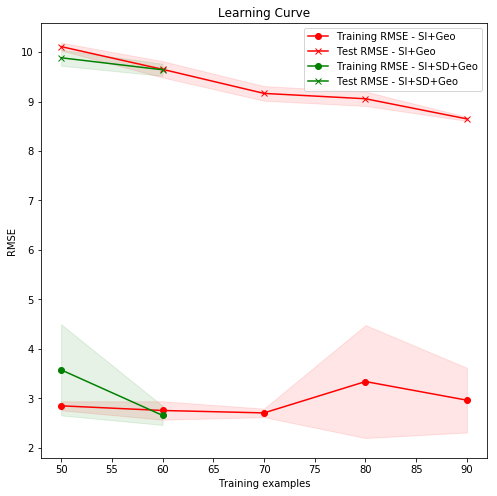

In [52]:
plot_results(results_df)

In [7]:
labelFromCode('1111')

'SI+SD+LS+Geo'